<a href="https://colab.research.google.com/github/MeghaGhosh/MeghaGhosh.github.io/blob/master/multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive and and change current working directory to drive location

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive


/content/drive


In [0]:
%cd 'My Drive'

/content/drive/My Drive


Make necessary imports

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import logging
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
#tf.enable_eager_execution()
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers


warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
%matplotlib inline


2.0.0


Using TensorFlow backend.


Read csv and remove unnecessary characters

In [0]:
annotations = pd.read_csv('task/annotation.csv')
annotations['labels']= annotations['labels'].str.replace(r"'", "")
annotations['labels']= annotations['labels'].str.replace(r"[", "")
annotations['labels']= annotations['labels'].str.replace(r"]", "")
annotations['labels']= annotations['labels'].str.replace(r" ", "")

In [0]:
annotations.head()


,image,labels
0,20151127_130005,"bread,pizzoccheri,potatoes,savory_pie"
1,20151204_121047,lasagna_bolognese
2,20151204_121641,lasagna_bolognese
3,20151211_134539_2,"bread,pasta,fillet_fish,potatoes,green_beans,y..."
4,20151130_114633_1,"bread,pasta,meat,peas"




```
`# This is formatted as code`
```

Check label frequency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text yticklabel objects>)

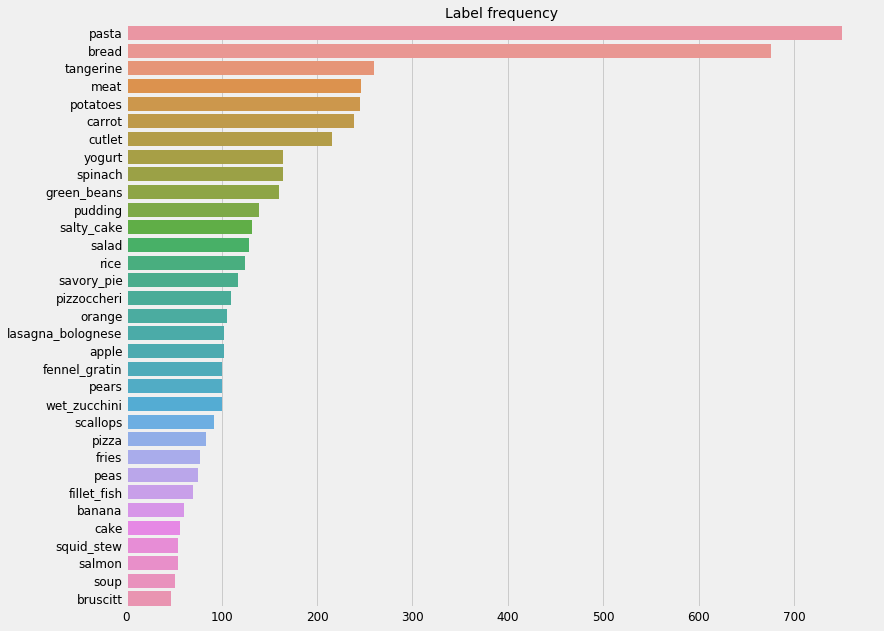

In [0]:
label_freq = annotations['labels'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [0]:
annotations['labels'] = annotations['labels'].apply(lambda s: [l for l in str(s).split(',')])
annotations.head()

,image,labels
0,20151127_130005,"[bread, pizzoccheri, potatoes, savory_pie]"
1,20151204_121047,[lasagna_bolognese]
2,20151204_121641,[lasagna_bolognese]
3,20151211_134539_2,"[bread, pasta, fillet_fish, potatoes, green_be..."
4,20151130_114633_1,"[bread, pasta, meat, peas]"


Get image paths

In [0]:
x = [os.path.join('./task/data', str(f)+'.jpg') for f in annotations['image']]
x[:3]

['./task/data/20151127_130005.jpg',
 './task/data/20151204_121047.jpg',
 './task/data/20151204_121641.jpg']

Print labels

In [0]:
y = [f for f in annotations['labels']]
y[:3]

[['bread', 'pizzoccheri', 'potatoes', 'savory_pie'],
 ['lasagna_bolognese'],
 ['lasagna_bolognese']]

In [0]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 256 # Big enough to measure an F1-score


Read and resize images

In [0]:
import cv2
from keras.preprocessing import image 
from keras.preprocessing.image import img_to_array

x_image =[]

for imgpath in x:
  print(imgpath)
  image = cv2.imread(imgpath)
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image = img_to_array(image)
  x_image.append(image)

./task/data/20151127_130005.jpg
./task/data/20151204_121047.jpg
./task/data/20151204_121641.jpg
./task/data/20151211_134539_2.jpg
./task/data/20151130_114633_1.jpg
./task/data/20151204_130615_2.jpg
./task/data/20151221_115609.jpg
./task/data/20151211_132926.jpg
./task/data/20151204_121520_2.jpg
./task/data/20151211_125042_1.jpg
./task/data/20151204_130733.jpg
./task/data/20151204_132509_1.jpg
./task/data/20151211_120256.jpg
./task/data/20151204_132239_1.jpg
./task/data/20151221_130014_2.jpg
./task/data/20151203_124923_3.jpg
./task/data/20151127_125520_3.jpg
./task/data/20151211_140232.jpg
./task/data/20151130_120059.jpg
./task/data/20151221_121154_2.jpg
./task/data/20151204_132341.jpg
./task/data/20151204_131728_2.jpg
./task/data/20151130_121414.jpg
./task/data/20151211_135540_1.jpg
./task/data/20151204_133650.jpg
./task/data/20151204_123442_2.jpg
./task/data/20151211_141344_1.jpg
./task/data/20151221_123252_3.jpg
./task/data/20151127_122910.jpg
./task/data/20151127_132932.jpg
./task/d

Normalise images and convert labels to numpy array

In [0]:
data = np.array(x_image, dtype="float") / 255.0
labels = np.array(y)

In [0]:
data

array([[[[0.        , 0.        , 0.01960784],
         [0.        , 0.        , 0.01568627],
         [0.00392157, 0.        , 0.01568627],
         ...,
         [0.01568627, 0.05882353, 0.02745098],
         [0.03137255, 0.04313725, 0.0627451 ],
         [0.04313725, 0.04705882, 0.08627451]],

        [[0.        , 0.        , 0.01960784],
         [0.        , 0.        , 0.01176471],
         [0.00392157, 0.        , 0.00784314],
         ...,
         [0.01568627, 0.03529412, 0.02745098],
         [0.03529412, 0.03529412, 0.05882353],
         [0.        , 0.        , 0.03529412]],

        [[0.00784314, 0.00392157, 0.01960784],
         [0.00392157, 0.        , 0.00784314],
         [0.        , 0.        , 0.00392157],
         ...,
         [0.04705882, 0.04313725, 0.05098039],
         [0.05098039, 0.03137255, 0.06666667],
         [0.28627451, 0.25490196, 0.29803922]],

        ...,

        [[0.28235294, 0.23137255, 0.16862745],
         [0.43529412, 0.38039216, 0.30980392]

In [0]:
labels

array([list(['bread', 'pizzoccheri', 'potatoes', 'savory_pie']),
       list(['lasagna_bolognese']), list(['lasagna_bolognese']), ...,
       list(['pasta', 'cutlet', 'peas']),
       list(['bread', 'orange', 'fennel_gratin', 'fennel_gratin', 'spinach', 'spinach']),
       list(['bread', 'pudding', 'pizzoccheri', 'meat', 'carrot'])],
      dtype=object)

Show individual images with their labels

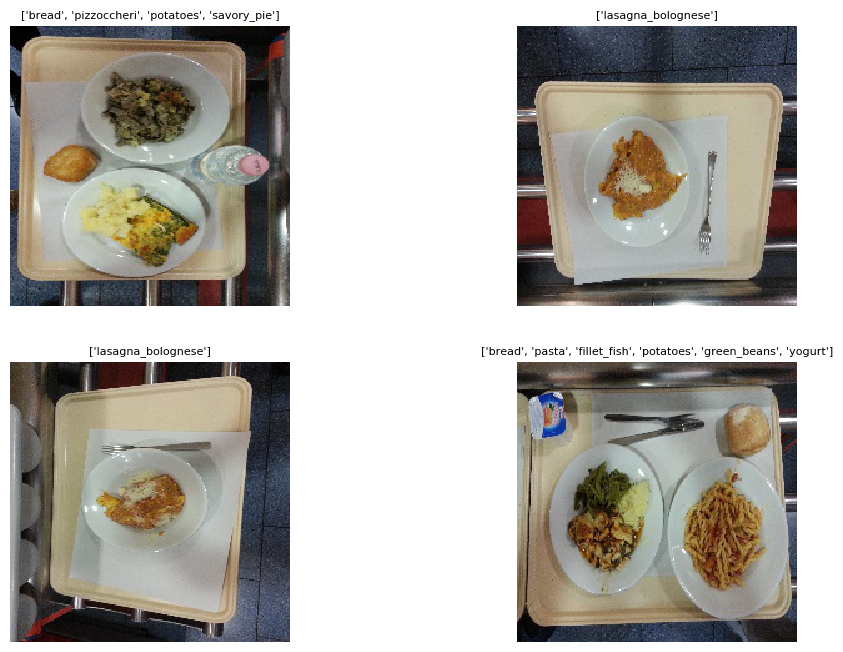

In [0]:
nobs = 4 # Maximum number of images to display
ncols = 2 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(x[i]))
    plt.title(labels[i], size=8)
    plt.axis('off')

Fit the labels and transform to one hot coded vectors, print all classes

In [0]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. apple
1. banana
2. bread
3. bruscitt
4. cake
5. carrot
6. cutlet
7. fennel_gratin
8. fillet_fish
9. fries
10. green_beans
11. lasagna_bolognese
12. meat
13. orange
14. pasta
15. pears
16. peas
17. pizza
18. pizzoccheri
19. potatoes
20. pudding
21. rice
22. salad
23. salmon
24. salty_cake
25. savory_pie
26. scallops
27. soup
28. spinach
29. squid_stew
30. tangerine
31. wet_zucchini
32. yogurt


labels are now one-hot encoded

In [0]:
labels

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

split data into train (70%), validation (15%) and test (15%)

In [0]:
# train is now 70% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5) 

print(x_train.shape, x_val.shape, x_test.shape)

(980, 224, 224, 3) (210, 224, 224, 3) (210, 224, 224, 3)


print final format of input data and their labels

In [0]:
# Print example of food and their binary targets
for i in range(3):
    print(x_train[i], y_train[i])

[[[0.24313725 0.27058824 0.32941176]
  [0.25098039 0.27843137 0.3372549 ]
  [0.24705882 0.2745098  0.33333333]
  ...
  [0.12156863 0.1254902  0.18039216]
  [0.13333333 0.14509804 0.2       ]
  [0.14117647 0.15294118 0.20784314]]

 [[0.2627451  0.29411765 0.34509804]
  [0.29019608 0.32156863 0.37254902]
  [0.25490196 0.28627451 0.3372549 ]
  ...
  [0.1254902  0.12941176 0.18431373]
  [0.16078431 0.17254902 0.22745098]
  [0.14509804 0.15686275 0.21176471]]

 [[0.28627451 0.32156863 0.36078431]
  [0.2745098  0.30980392 0.34901961]
  [0.30196078 0.3372549  0.37647059]
  ...
  [0.20392157 0.21960784 0.2627451 ]
  [0.18431373 0.2        0.24313725]
  [0.19215686 0.20784314 0.25098039]]

 ...

 [[0.1254902  0.11372549 0.08235294]
  [0.12156863 0.10980392 0.07843137]
  [0.14117647 0.12941176 0.09803922]
  ...
  [0.16470588 0.13333333 0.10588235]
  [0.21960784 0.18431373 0.16862745]
  [0.21568627 0.18039216 0.16470588]]

 [[0.1254902  0.11372549 0.08235294]
  [0.14509804 0.13333333 0.10196078]


download mobilenetv2 and create mobilenet layer

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

make mobilenet layers not trainable

In [0]:

feature_extractor_layer.trainable = False

create model by adding more hidden layers with relu activation function and an output layer with activation function sigmoid

In [0]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(1024, activation='relu', name='hidden_layer2'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
output (Dense)               (None, 33)                33825     
Total params: 4,653,153
Trainable params: 2,395,169
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 100

function to compute macro f1 score on a batch of observations

In [0]:
@tf.function
def macro_f1_(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

function that computes macro soft f1-score as a cost

In [0]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

compile model with optimier as Adam, loss and metrics as previously defined functions

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1_])

In [0]:
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []

In [0]:
from sklearn.metrics import f1_score

compute f1 score for train data at end of epoch

In [0]:
class TrainCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_data):
        self.train_data = train_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.train_data
        y_pred = (model.predict(x) > 0.5).astype('int')
        f1 = f1_score(y, y_pred , average='samples')
        print('\nTesting F1 Score: {}'.format(f1))
        train_f1_scores.append(f1)

compute f1 score for val data at end of epoch

In [0]:
class ValCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs={}):
        #x, y = self.val_data
        #f1_score = self.model.evaluate(x, y, verbose=0)
        x, y = self.val_data
        y_pred = (model.predict(x) > 0.5).astype('int')
        f1 = f1_score(y, y_pred , average='samples')
        print('Validation F1 Score: {}\n'.format(f1))
        val_f1_scores.append(f1)

compute f1 score for test data at end of epoch

In [0]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        y_pred = (model.predict(x) > 0.5).astype('int')
        f1 = f1_score(y, y_pred , average='samples')
        print('\nTesting F1 Score: {}'.format(f1))
        test_f1_scores.append(f1)

Model training - output to logs.txt file

In [0]:
import sys

oldStdout = sys.stdout
file = open('logs1', 'w')
sys.stdout = file 
history = model.fit(
    x_train, y_train, 
    batch_size = BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks = [TrainCallback((x_train,y_train)),ValCallback((x_val, y_val)),TestCallback((x_test,y_test))]
    )
sys.stdout = oldStdout


print train, val and test f1 scores after each epoch

In [0]:
train_f1_scores

In [0]:
val_f1_scores

[0.21103460461171553,
 0.2125664835183453,
 0.21486024838447454,
 0.21672353970961808,
 0.2166777084991211]

In [0]:
test_f1_scores

[0.2093528805452406,
 0.2118534898829135,
 0.21518917604067253,
 0.2164674981799513,
 0.2169303900723922,
 0.21848753710510102,
 0.21933686337422142,
 0.2198618571632473,
 0.2200229252581993,
 0.22267746188767065,
 0.22430587290127624,
 0.2248382519910978,
 0.22604967252660169,
 0.22696651216829433,
 0.2280017461172356,
 0.2282532771944063,
 0.2295572632231457,
 0.2302363857326969,
 0.23094480825997038,
 0.23207785217502422,
 0.23411574567019283,
 0.23609645047851208,
 0.2382651409081808,
 0.2406236658020217,
 0.24290817223515893,
 0.24513944748131747,
 0.24826631818518372,
 0.24945993832348143,
 0.25187869312040034,
 0.2546716068059067,
 0.2579297072650084,
 0.26089160229691544,
 0.2632706919030849,
 0.26549163965393485,
 0.2675960569897362,
 0.26909743702146066,
 0.2712144313615094,
 0.27644219048597646,
 0.2804189482534962,
 0.284861725291412,
 0.28842253872526163,
 0.2922077020431923,
 0.2969472266689254,
 0.298020801428201,
 0.3021946146008219,
 0.3053454505754373,
 0.309959642467

In [0]:
tf.keras.experimental.export_saved_model(model, '100epochschumma.h5')


/content/drive/My Drive


In [0]:
from keras.preprocessing import image

def show_prediction(img_path, model):
    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.show()

In [0]:
ls

'20151127_114556 (1).jpg'   20151203_130658_2.jpg    20151211_125203.jpg
 20151127_114556.jpg        20151203_130658_3.jpg    20151211_125223.jpg
'20151127_114946 (1).jpg'   20151203_130658.jpg      20151211_125307.jpg
 20151127_114946.jpg        20151203_130726.jpg      20151211_125634.jpg
'20151127_115133 (1).jpg'   20151203_130936.jpg      20151211_125736.jpg
 20151127_115133.jpg        20151203_130958_1.jpg    20151211_125829.jpg
 20151127_115229.jpg        20151203_130958_2.jpg    20151211_125845_2.jpg
 20151127_115424.jpg        20151203_130958.jpg      20151211_125845.jpg
 20151127_115553_1.jpg      20151203_131008_1.jpg    20151211_1259000.jpg
 20151127_115553_2.jpg      20151203_131008.jpg      20151211_125942.jpg
 20151127_115553.jpg        20151203_131054_1.jpg    20151211_130024.jpg
 20151127_115951.jpg        20151203_131054_2.jpg    20151211_130033_1.jpg
 20151127_120002_2.jpg      20151203_131054_3.jpg    20151211_130033_2.jpg
 20151127_120002_3.jpg      20151203_131054.

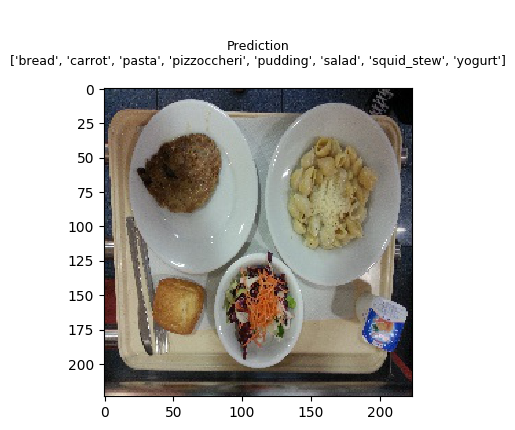

In [0]:
show_prediction('20151211_125203_3.jpg', model)

compute train and val f1 scores for all predictions on val and test data with trained model

In [0]:
def compute_f1_score(y_true, y_pred):
  f1 = f1_score(y_true,y_pred,average='samples')
  print(f1)

In [0]:
y_train_pred = (model.predict(x_train) > 0.5).astype('int')
f1_train = compute_f1_score(y_train, y_train_pred)


0.5644045709227835


In [0]:
y_val_pred = (model.predict(x_val) > 0.5).astype('int')
compute_f1_score(y_val, y_val_pred)

0.476230231020147


In [0]:
y_test_pred = (model.predict(x_test) > 0.5).astype('int')
compute_f1_score(y_test, y_test_pred)

0.46165868523011383


In [0]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_test_pred)

In [0]:
def plot_classification_report(cr, title='Report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
     #print(line) t = line.split() # print(t) if(len(t)==0): break
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        if(len(t)==0): break
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap='RdBu')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

[0.31, 0.29, 0.3]
[0.0, 0.0, 0.0]
[0.45, 0.99, 0.62]
[1.0, 0.2, 0.33]
[0.0, 0.0, 0.0]
[0.32, 0.66, 0.43]
[0.41, 0.39, 0.4]
[0.5, 0.45, 0.48]
[0.0, 0.0, 0.0]
[1.0, 0.62, 0.77]
[0.65, 0.55, 0.59]
[0.78, 0.7, 0.74]
[0.31, 0.57, 0.4]
[0.5, 0.33, 0.4]
[0.53, 1.0, 0.69]
[0.57, 0.4, 0.47]
[1.0, 0.12, 0.22]
[0.91, 0.77, 0.83]
[0.46, 0.38, 0.41]
[0.35, 0.52, 0.42]
[0.38, 0.26, 0.31]
[0.6, 0.53, 0.56]
[0.19, 0.28, 0.23]
[0.0, 0.0, 0.0]
[0.36, 0.18, 0.24]
[0.69, 0.47, 0.56]
[0.25, 0.21, 0.23]
[1.0, 0.25, 0.4]
[0.26, 0.3, 0.28]
[1.0, 0.44, 0.62]
[0.35, 0.27, 0.31]
[0.42, 0.24, 0.3]
[0.67, 0.41, 0.51]


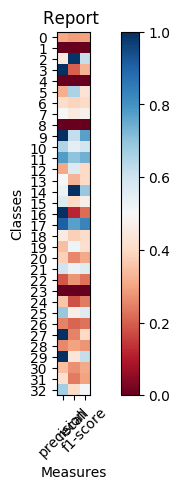

In [0]:
plot_classification_report(cr)

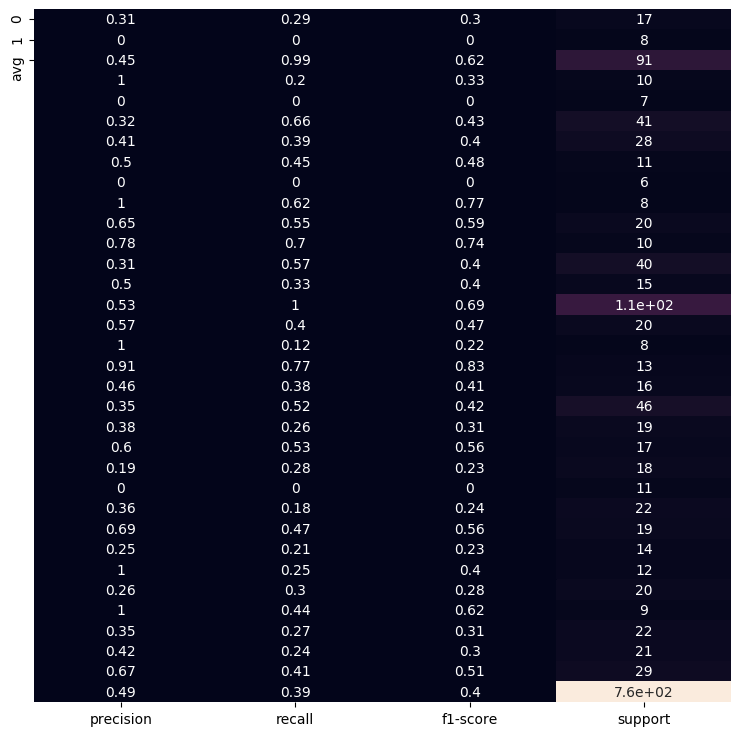

In [0]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

y = np.random.randint(low=0, high=10, size=100)
y_p = np.random.randint(low=0, high=10, size=100)

def plot_classification_report(y_test, y_test_pred, figsize=(9, 9), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_test))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_test, y_test_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y_test, y_test_pred)

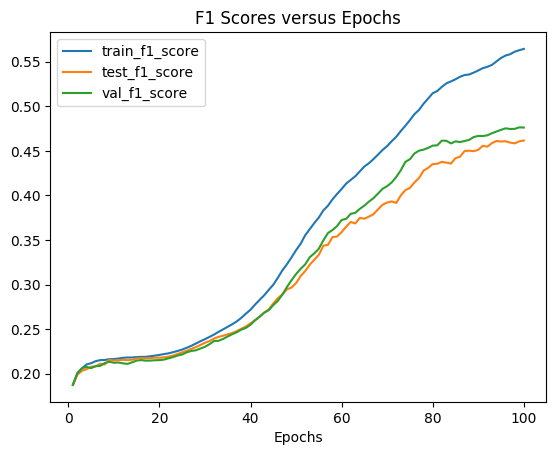

In [0]:
b = np.linspace(1.0, 100.0, num=100)
plt.plot(b, train_f1_scores, label = "train_f1_score") 
plt.plot(b, test_f1_scores, label = "test_f1_score")
plt.plot(b, val_f1_scores, label = "val_f1_score")
plt.xlabel('Epochs')
plt.title('F1 Scores versus Epochs')
plt.legend()